In [56]:
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.mixture import GaussianMixture
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [57]:
iris = load_iris(as_frame = True)
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

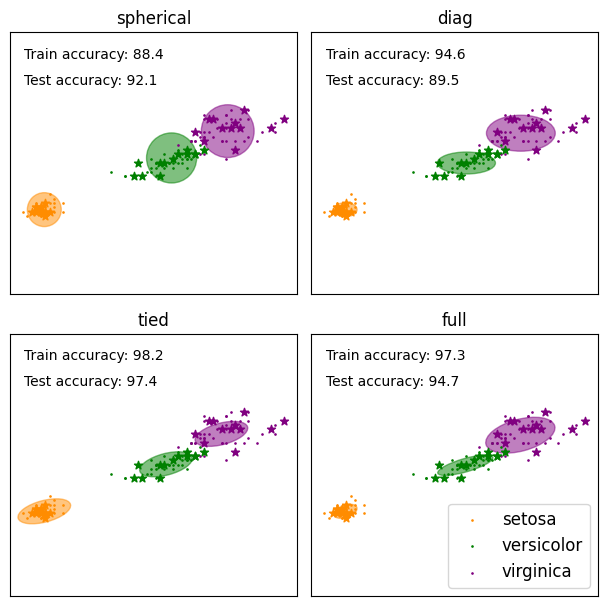

In [58]:
colors = ["darkorange", "green", "purple"]

def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][2:4, 2:4]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[2:4, 2:4]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][2:4])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, 2:4], v[0], v[1], angle=180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")

iris = load_iris()

data = iris.data
labels = iris.target
labels_names = iris.target_names

X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.25, stratify = labels
    )

n_classes = len(labels_names)

# Try GMMs using different types of covariances.
estimators = {
    cov_type: GaussianMixture(
        n_components=n_classes, covariance_type=cov_type, max_iter=20, random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(
    bottom=0.01, top=0.95, hspace=0.15, wspace=0.05, left=0.01, right=0.99
)

for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array(
        [X_train[y_train == i].mean(axis=0) for i in range(n_classes)]
    )

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data_aux = iris.data[iris.target == n]
        plt.scatter(
            data_aux[:, 2], data_aux[:, 3], s=0.8, color=color, label=iris.target_names[n]
        )
        
    # Plotear la data con estrellas
    for n, color in enumerate(colors):
        data_aux = X_test[y_test == n]
        plt.scatter(data_aux[:, 2], data_aux[:, 3], marker="*", color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, "Train accuracy: %.1f" % train_accuracy, transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, "Test accuracy: %.1f" % test_accuracy, transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc="lower right", prop=dict(size=12))
plt.show()

PCA explained variance ratio (first two components): [0.92461872 0.05306648]
LDA explained variance ratio (first two components): [0.9912126 0.0087874]


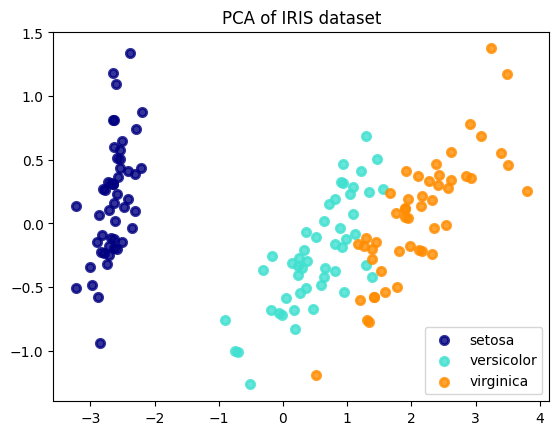

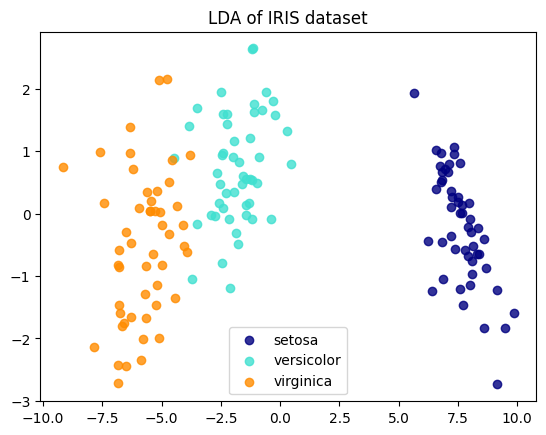

In [59]:
pca = PCA(n_components=2)
X_r = pca.fit(data).transform(data)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(data, labels).transform(data)

# Percentage of variance explained for each components
print(f"PCA explained variance ratio (first two components): {pca.explained_variance_ratio_}")
print(f"LDA explained variance ratio (first two components): {lda.explained_variance_ratio_}")


plt.figure()
colors = ["navy", "turquoise", "darkorange"]
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], labels_names):
    plt.scatter(
        X_r[labels == i, 0], X_r[labels == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of IRIS dataset")

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], labels_names):
    plt.scatter(
        X_r2[labels == i, 0], X_r2[labels == i, 1], alpha=0.8, color=color, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of IRIS dataset")

plt.show()

In [60]:
cancer = load_breast_cancer()
print(cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [61]:
cancer_d = cancer.data
cancer_l = cancer.target
labels_names = cancer.target_names

pca = PCA(n_components=10)
X_r = pca.fit(cancer_d).transform(cancer_d)
print(f"PCA explained variance ratio (firratist ten components): {pca.explained_variance_ratio_}")

PCA explained variance ratio (firratist ten components): [9.82044672e-01 1.61764899e-02 1.55751075e-03 1.20931964e-04
 8.82724536e-05 6.64883951e-06 4.01713682e-06 8.22017197e-07
 3.44135279e-07 1.86018721e-07]


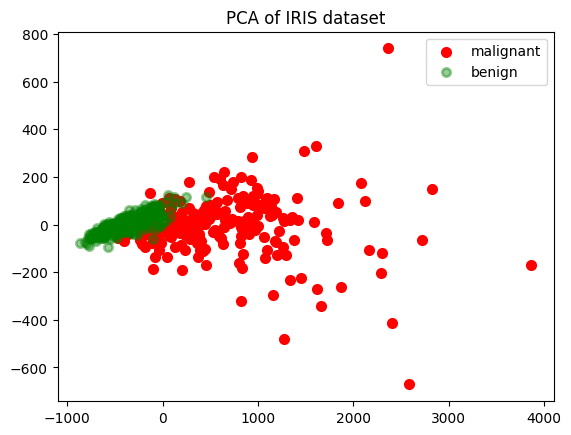

In [62]:
plt.figure()
colors = ["red", "green"]
lw = 2
sombra = [1, 0.4]
for color, i, target_name, s in zip(colors, [0, 1], labels_names, sombra):
    plt.scatter(
        X_r[cancer_l == i, 0], X_r[cancer_l == i, 1], color=color, alpha=s, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of IRIS dataset")



plt.show()

In [63]:
scaler = StandardScaler()

normaliced_cancer = scaler.fit_transform(cancer_d) 

X_train, X_test, y_train, y_test = train_test_split(
    normaliced_cancer, cancer_l, test_size = 0.25, stratify = cancer_l
) #Siempre es recomendable mantener la proporcion de los datos?

print(sum(y_train)/sum(cancer_l))

0.7478991596638656


In [64]:
model = GaussianNB()

model.fit(X_train, y_train)

GaussianNB()

              precision    recall  f1-score   support

   malignant       0.98      0.96      0.97        53
      benign       0.98      0.99      0.98        90

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



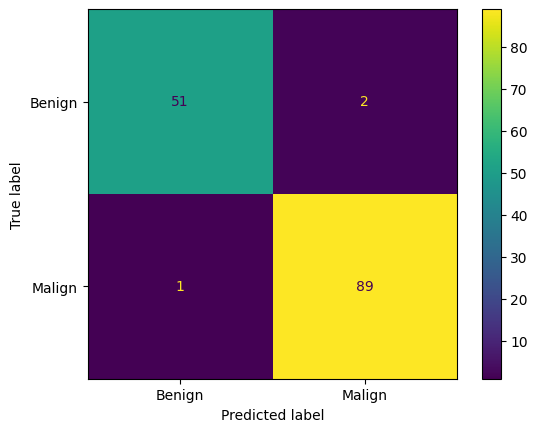

In [65]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=labels_names))

labels = ["Benign", "Malign"]
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

              precision    recall  f1-score   support

   malignant       0.95      0.75      0.84        53
      benign       0.87      0.98      0.92        90

    accuracy                           0.90       143
   macro avg       0.91      0.87      0.88       143
weighted avg       0.90      0.90      0.89       143



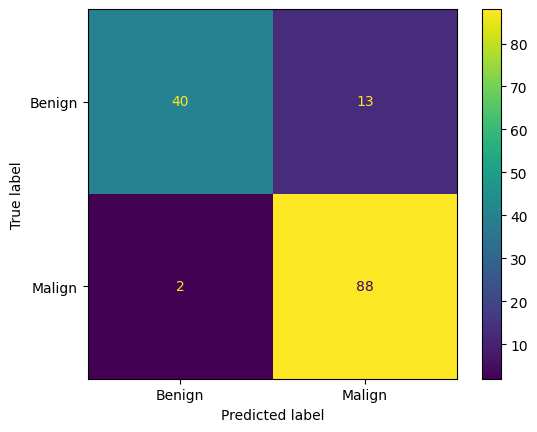

In [66]:
pca = PCA(n_components=3)

pca_data = pca.fit(cancer_d).transform(cancer_d)

normaliced_pca_cancer = scaler.fit_transform(pca_data) 

X_train, X_test, y_train, y_test = train_test_split(
    normaliced_pca_cancer, cancer_l, test_size = 0.25, stratify = cancer_l
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=labels_names))

labels = ["Benign", "Malign"]
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

Ejercicio 4

In [68]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people (min_faces_per_person=60)
print(faces.target_names)
print(faces.data[1])

XF = faces.data
yF = faces.target

target_names = faces.target_names

n_samples, h , w = faces.images.shape

['George W Bush' 'Gerhard Schroeder']
[0.14509805 0.16993465 0.30588236 ... 0.4771242  0.86928105 0.951634  ]
